In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!unzip /content/drive/MyDrive/CompVisProject/dataset.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_1.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_2.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_3.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_4.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_5.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_6.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_7.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_8.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_9.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_1.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_2.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_3.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_4.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_5.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_6.jpg  
  inflating: /content/dataset/Aldo

In [ ]:
!pip install mediapipe
import cv2
import mediapipe as mp
import numpy as np
import os

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def get_bounding_box(image):
    """Detect hand and return bounding box coordinates."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get bounding box coordinates
            h, w, _ = image.shape
            x_min = min([lm.x for lm in hand_landmarks.landmark]) * w
            y_min = min([lm.y for lm in hand_landmarks.landmark]) * h
            x_max = max([lm.x for lm in hand_landmarks.landmark]) * w
            y_max = max([lm.y for lm in hand_landmarks.landmark]) * h
            return int(x_min), int(y_min), int(x_max), int(y_max)
    return None


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 63.6 MB/s eta 0:00:00


In [ ]:
dataset_path = "dataset/Aldos Pics"
cropped_images_path = "cropped_hands"

if not os.path.exists(cropped_images_path):
    os.makedirs(cropped_images_path)

for label_folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, label_folder)
    output_label_folder = os.path.join(cropped_images_path, label_folder)
    os.makedirs(output_label_folder, exist_ok=True)

    for img_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, img_file)
        image = cv2.imread(image_path)
        bbox = get_bounding_box(image)

        if bbox:
            x_min, y_min, x_max, y_max = bbox

            # Ensure bounding box coordinates are within image bounds
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image.shape[1], x_max)
            y_max = min(image.shape[0], y_max)

            cropped_image = image[y_min:y_max, x_min:x_max]

            # Check if cropped_image is valid before resizing
            if cropped_image.size > 0: #Check if the cropped image is not empty
                resized_image = cv2.resize(cropped_image, (224, 224))  # Resize to match CNN input size
                output_path = os.path.join(output_label_folder, img_file)
                cv2.imwrite(output_path, resized_image)
            else:
                print(f"Skipping image {img_file} due to invalid cropping region.")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training and validation data
train_data = datagen.flow_from_directory(
    cropped_images_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    cropped_images_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 16189 images belonging to 24 classes.
Found 4036 images belonging to 24 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load a pretrained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(train_data.class_indices), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

# Save the model
model.save("hand_sign_model.h5")
print("Model saved as 'hand_sign_model.h5'")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


506/506 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.8083 - loss: 0.7255 - val_accuracy: 0.9703 - val_loss: 0.1064
Epoch 2/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9794 - loss: 0.0746 - val_accuracy: 0.9802 - val_loss: 0.0713
Epoch 3/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9887 - loss: 0.0410 - val_accuracy: 0.9755 - val_loss: 0.0778
Epoch 4/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9909 - loss: 0.0324 - val_accuracy: 0.9827 - val_loss: 0.0620
Epoch 5/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.9912 - loss: 0.0303 - val_accuracy: 0.9792 - val_loss: 0.0657
Epoch 6/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9932 - loss: 0.0214 - val_accuracy: 0.9777 - val_loss: 0.0775
Epoch 7/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9914 - loss: 0.0256 - val_accuracy: 0.9755 - val_loss: 0.0880
Epoch 8/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9947 - loss: 0.0164 - val_accurac

Model saved as 'hand_sign_model.h5'


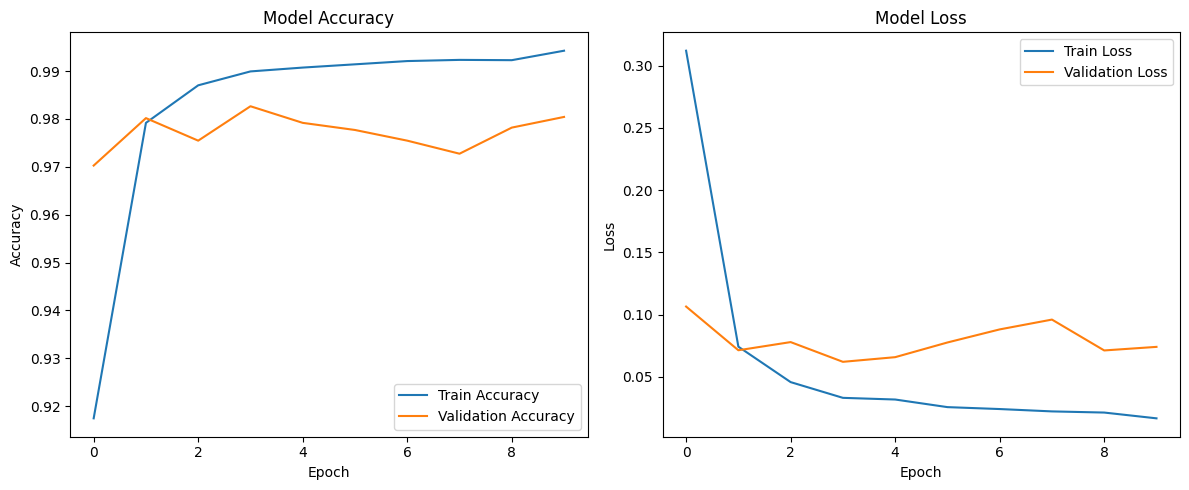

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    """Plots accuracy and loss for training and validation sets."""
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_training_metrics(history)
